Source tutorial: [Z-score for anomaly detection](https://towardsdatascience.com/z-score-for-anomaly-detection-d98b0006f510)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
for dirname, _, filenames in os.walk('./input/gearbox-fault-diagnosis'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/gearbox-fault-diagnosis/BrokenTooth/b30hz40.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz60.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz30.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz0.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz20.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz70.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz10.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz50.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz80.csv
./input/gearbox-fault-diagnosis/BrokenTooth/b30hz90.csv
./input/gearbox-fault-diagnosis/Healthy/h30hz10.csv
./input/gearbox-fault-diagnosis/Healthy/h30hz80.csv
./input/gearbox-fault-diagnosis/Healthy/h30hz40.csv
./input/gearbox-fault-diagnosis/Healthy/h30hz70.csv
./input/gearbox-fault-diagnosis/Healthy/h30hz90.csv
./input/gearbox-fault-diagnosis/Healthy/h30hz0.csv
./input/gearbox-fault-diagnosis/Healthy/h30hz20.csv
./input/gearbox-fault-diagnosis/Healthy/h30hz50.csv
./input/gearbox-fault-diag

In [2]:
# LOAD DATASETS CORRESPONDING TO 50% LOAD
# Healthy gearbox
# ---------------
healthy_dataset = pd.read_csv("./input/gearbox-fault-diagnosis/Healthy/h30hz50.csv")
# Broken gearbox
# ---------------
broken_dataset = pd.read_csv("./input/gearbox-fault-diagnosis/BrokenTooth/b30hz50.csv")

In [3]:
print("healthy_dataset's shape is", healthy_dataset.shape, "while broken_dataset's is", broken_dataset.shape)

healthy_dataset's shape is (110848, 4) while broken_dataset's is (94208, 4)


# Input parameters for the analysis

In [4]:
# TELL ME HOW BIG THE SAMPLE YOU'D LIKE IT TO BE
size_of_sample = 1000

# SET THE THRESHOLD FOR DETECTING OUTLIERS
#  - If 2: 95% probability, outlier if within 5% probability edge
#  - If 3: 99% probability, outlier if in 1% probability edge
## https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_probability/bs704_probability10.html
threshold = 2

# Compare dataset to a normal distribution

In [5]:
a1h = np.array(healthy_dataset['a1'].head(size_of_sample))
a1b = np.array(broken_dataset['a1'].head(size_of_sample))
print("Healthy a1 sample lenght is", a1h.size, "while broken is", a1b.size)

Healthy a1 sample lenght is 1000 while broken is 1000


In [6]:
# calculate mean
mean_a1h = np.mean(a1h)
mean_a1b = np.mean(a1b)
print("Mean for a1h is", "{:.3f}".format(mean_a1h),  "while for broken is","{:.3f}".format(mean_a1b) )

Mean for a1h is 0.087 while for broken is -0.012


In [7]:
# calculate standard deviation
sd_a1h = np.std(a1h)
sd_a1b = np.std(a1b)
print("Standard deviation for a1h is", "{:.3f}".format(sd_a1h), "while for broken is", "{:.3f}".format(sd_a1b) )

Standard deviation for a1h is 7.166 while for broken is 4.262


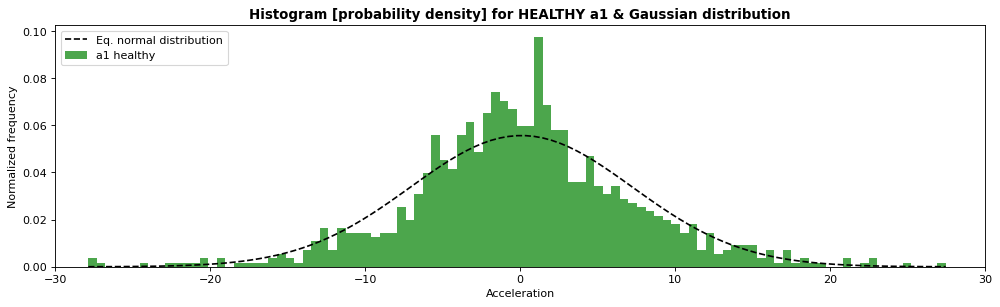

In [8]:
# https://www.geeksforgeeks.org/matplotlib-pyplot-hist-in-python/
nbins=100
figure(figsize=(15, 4), dpi=80)

n, bins, patches = plt.hist(a1h, nbins, density = True, label='a1 healthy', color ='green',alpha = 0.7)
y = ((1 / (np.sqrt(2 * np.pi) * sd_a1h)) *
     np.exp(-0.5 * (1 / sd_a1h * (bins - mean_a1h))**2))
plt.plot(bins, y, '--', label='Eq. normal distribution', color ='black')

plt.xlabel('Acceleration')
plt.xlim(-30,30)
plt.ylabel('Normalized frequency')
plt.legend(loc="upper left")  
plt.title('Histogram [probability density] for HEALTHY a1 & Gaussian distribution', fontweight ="bold")
plt.show()

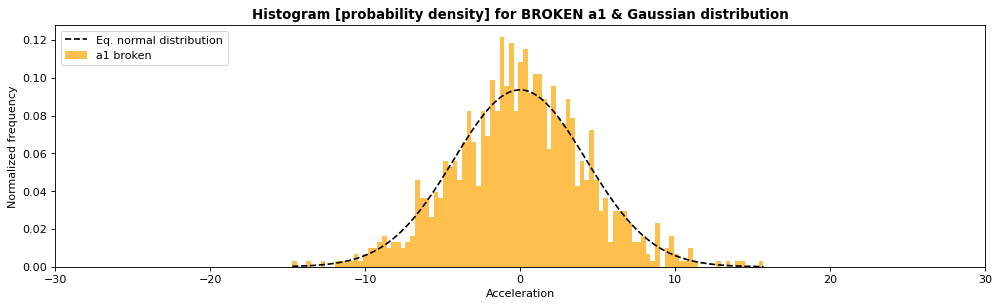

In [9]:
figure(figsize=(15, 4), dpi=80)
n, bins, patches = plt.hist(a1b, nbins, density = True, label='a1 broken', color ='orange',alpha = 0.7)
y = ((1 / (np.sqrt(2 * np.pi) * sd_a1b)) *
     np.exp(-0.5 * (1 / sd_a1b * (bins - mean_a1b))**2))
plt.plot(bins, y, '--', label='Eq. normal distribution', color ='black')

plt.xlabel('Acceleration')
plt.xlim(-30,30)
plt.ylabel('Normalized frequency')
plt.legend(loc="upper left")  
plt.title('Histogram [probability density] for BROKEN a1 & Gaussian distribution', fontweight ="bold")
plt.show()

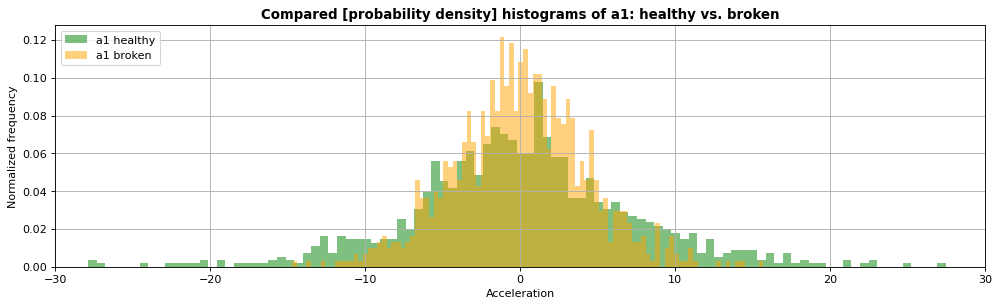

In [10]:
figure(figsize=(15, 4), dpi=80)

# In this case, we'll plot from the dataframe taking the first 1000 points (equivalent to a1h numpy array)
healthy_dataset['a1'].head(size_of_sample).hist(bins=nbins, density=True, label='a1 healthy', color ='green', alpha = 0.5)
broken_dataset['a1'].head(size_of_sample).hist(bins=nbins, density=True, label='a1 broken', color ='orange', alpha = 0.5)

plt.xlabel('Acceleration')
plt.xlim(-30,30)
plt.ylabel('Normalized frequency')

plt.legend(loc="upper left")  
plt.title('Compared [probability density] histograms of a1: healthy vs. broken', fontweight ="bold")
plt.show()

In [11]:
# create empty list to store outliers
outliersHealthy = []
outliersBroken  = []
outliersHealthy_index = []
outliersBroken_index  = []

# detect outliers for HEALTHY gearbox
index = 0
for i in a1h: 
    z = (i-mean_a1h)/sd_a1h # calculate z-score
    if abs(z) > threshold:  # identify outliers
        outliersHealthy.append(i) # add to the empty list
        outliersHealthy_index.append(index)
    index+= 1

# detect outliers for BROKEN gearbox
index = 0
for i in a1b: 
    z = (i-mean_a1b)/sd_a1b # calculate z-score
    if abs(z) > threshold:  # identify outliers
        outliersBroken.append(i) # add to the empty list
        outliersBroken_index.append(index)
    index+= 1
        
# print outliers    
print(" * The detected outliers in the HEALTHY gearbox are: ", outliersHealthy)
print(" * Positional index of HEALTHY gearbox outliers are: ", outliersHealthy_index)
print("\n * The detected outliers in the BROKEN gearbox are: ", outliersBroken)
print(" * Positional index of BROKEN gearbox outliers are: ", outliersBroken_index)

 * The detected outliers in the HEALTHY gearbox are:  [16.1343, 14.8105, -20.2453, -14.3628, -21.9742, 17.6022, -27.3513, 15.5848, 16.0263, 14.598, 17.2879, -17.0294, -20.747, 20.8453, -19.0574, 21.1944, 14.7899, -20.3529, 16.6571, 18.5021, -19.0856, 22.8593, -14.6924, 22.7634, -18.1458, -16.0918, 15.2581, -16.3987, 14.5304, -15.5315, 16.1181, 19.4399, -16.0485, -26.8395, 17.2722, -15.3178, 18.885, 15.0405, 14.4927, 24.8568, 18.1539, -27.8576, 17.0765, -15.0555, 22.4274, -17.713, -21.3332, 15.9443, 27.461, -24.4142, 14.8983, -22.3408, -15.3251, 15.3133, 17.0765]
 * Positional index of HEALTHY gearbox outliers are:  [10, 19, 20, 26, 161, 293, 297, 299, 334, 347, 450, 452, 471, 473, 475, 477, 483, 485, 487, 491, 586, 588, 605, 621, 673, 722, 724, 767, 769, 771, 776, 779, 780, 781, 783, 788, 789, 796, 891, 897, 900, 902, 904, 909, 911, 915, 916, 917, 918, 920, 921, 923, 929, 935, 971]

 * The detected outliers in the BROKEN gearbox are:  [9.87637, -9.42848, 10.1761, -8.66903, 9.82115, 10.

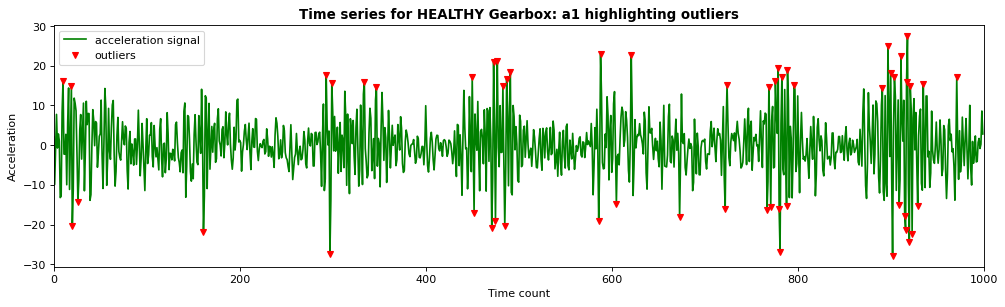

In [12]:
figure(figsize=(15, 4), dpi=80)

a1h_index = healthy_dataset.head(size_of_sample).index.values
plt.plot(a1h_index, a1h, color='green', label='acceleration signal')
plt.plot(outliersHealthy_index, outliersHealthy, 'v', color='red', label='outliers')

plt.xlabel('Time count')
plt.xlim(0,size_of_sample)
plt.ylabel('Acceleration')

plt.legend(loc="upper left")  
plt.title('Time series for HEALTHY Gearbox: a1 highlighting outliers', fontweight ="bold")
plt.show()

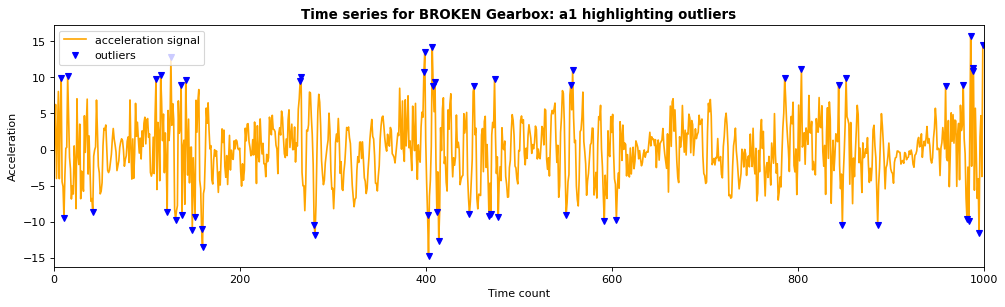

In [13]:
figure(figsize=(15, 4), dpi=80)

a1b_index = broken_dataset.head(size_of_sample).index.values
plt.plot(a1b_index, a1b, color='orange', label='acceleration signal')
plt.plot(outliersBroken_index, outliersBroken, 'v', color='blue', label='outliers')

plt.xlabel('Time count')
plt.xlim(0,size_of_sample)
plt.ylabel('Acceleration')

plt.legend(loc="upper left")  
plt.title('Time series for BROKEN Gearbox: a1 highlighting outliers', fontweight ="bold")
plt.show()

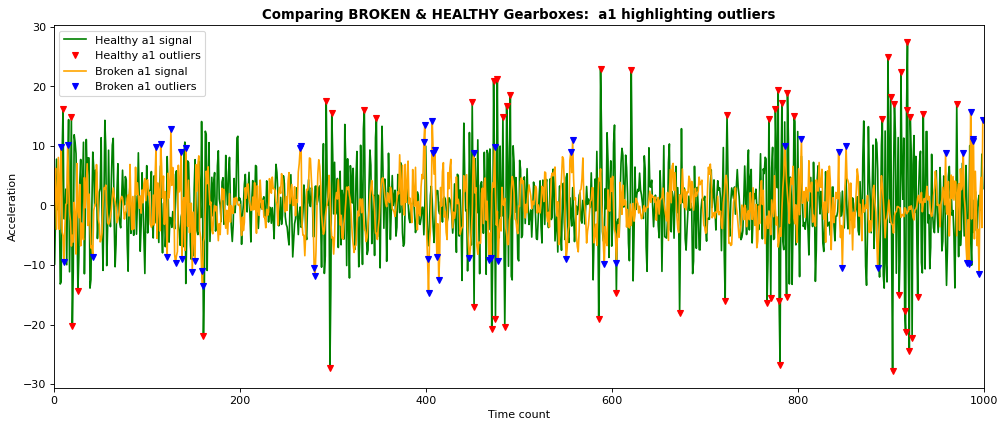

In [14]:
figure(figsize=(15, 6), dpi=80)

a1h_index = healthy_dataset.head(size_of_sample).index.values
plt.plot(a1h_index, a1h, color='green', label='Healthy a1 signal')
plt.plot(outliersHealthy_index, outliersHealthy, 'v', color='red', label='Healthy a1 outliers')

plt.plot(a1b_index, a1b, color='orange', label='Broken a1 signal')
plt.plot(outliersBroken_index, outliersBroken, 'v', color='blue', label='Broken a1 outliers')

plt.xlabel('Time count')
plt.xlim(0,size_of_sample)
plt.ylabel('Acceleration')

plt.legend(loc="upper left")  
plt.title('Comparing BROKEN & HEALTHY Gearboxes:  a1 highlighting outliers', fontweight ="bold")
plt.show()